In [20]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [21]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [22]:
def recursive_predict(model, initial_sequence, prediction_length, device='cpu'):
    model.eval()
    predictions = []
    input_seq = initial_sequence.clone()
    hidden = None
    
    with torch.no_grad():
        output, hidden = model(input_seq, hidden)
        last_pred = output[:, -1:, :]
        for _ in range(prediction_length):
            output, hidden = model(last_pred, hidden)
            predictions.append(output)
            last_pred = output
    return torch.cat(predictions, dim=1)

In [23]:
def generate_synthetic_data(seq_length, num_points):
    # Generate time points
    t = np.linspace(0, 20, num_points)
    # Create a combination of sine waves with noise
    data = (np.sin(t) + 
            0.5 * np.sin(2*t) + 
            0.1 * np.random.normal(0, 1, num_points))
    return torch.FloatTensor(data).reshape(1, -1, 1)

In [24]:
def plot_results(original_data, predictions, seq_length, train_losses):
    # Convert tensors to numpy for plotting
    original = original_data.squeeze().numpy()
    pred = predictions.squeeze().numpy()
    
    # Create time axes
    t_original = np.arange(len(original))
    t_pred = np.arange(seq_length, seq_length + len(pred))
    
    # Create figure with two subplots
    fig = plt.figure(figsize=(15, 10))
    
    # Plot 1: Time series
    plt.subplot(2, 1, 1)
    plt.plot(t_original, original, 'b-', label='Original Data')
    plt.plot(t_pred, pred, 'r--', label='Predictions')
    plt.axvline(x=seq_length, color='k', linestyle='--', alpha=0.3)
    plt.title('Time Series Forecasting with RNN')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Training loss
    plt.subplot(2, 1, 2)
    plt.plot(train_losses, 'g-', label='Training Loss')
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Epoch 0, Loss: 0.5502
Epoch 50, Loss: 0.0208
Epoch 100, Loss: 0.0118
Epoch 150, Loss: 0.0083


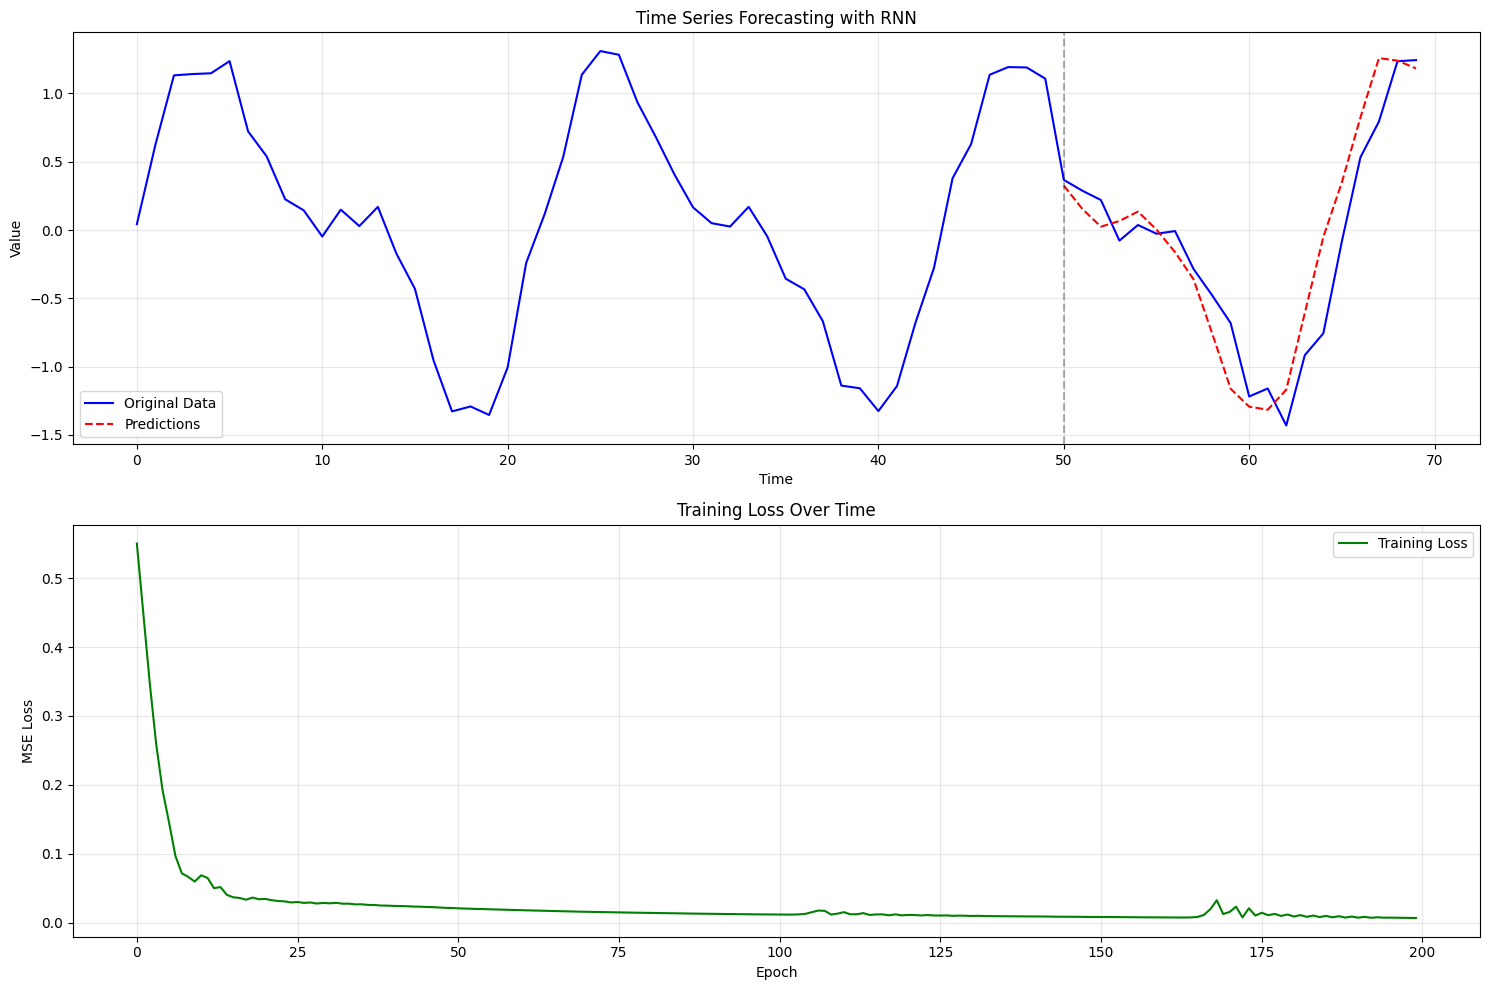


Test MSE: 0.0804


In [25]:
def main():
    # Hyperparameters
    input_size = 1
    hidden_size = 32
    output_size = 1
    seq_length = 50
    prediction_length = 20
    num_epochs = 200
    batch_size = 1
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Generate synthetic data
    total_points = seq_length + prediction_length
    data = generate_synthetic_data(seq_length, total_points)
    
    # Split into input sequence
    input_seq = data[:, :seq_length, :].to(device)
    target_seq = data[:, 1:seq_length+1, :].to(device)  # Next step prediction
    
    # Initialize model
    model = SimpleRNN(input_size, hidden_size, output_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # Training
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        hidden = model.init_hidden(batch_size).to(device)
        output, hidden = model(input_seq, hidden)
        
        loss = criterion(output, target_seq)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    
    # Make predictions
    predictions = recursive_predict(model, input_seq, prediction_length, device)
    
    # Plot results
    plot_results(data, predictions, seq_length, train_losses)
    
    # Calculate and print final MSE
    test_target = data[:, seq_length:seq_length+prediction_length, :]
    test_mse = criterion(predictions, test_target).item()
    print(f'\nTest MSE: {test_mse:.4f}')

if __name__ == "__main__":
    main()